In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.colors as colors
import h5py
import mat73
import matplotlib
import nbimporter
from importlib import reload
from _create_pdf import create_spins
from _helper_functions import replace_in_file, tsallis, cauchy, find_nearest_index, correct_for_fano
from _steady_state import a_steady, a_steady_hp
import _spin_params as spin_pars
# %qtconsole

In [2]:
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr
kappa = np.pi*fr/quali  # HWHM
delta = spin_pars.delta  # detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac  # detuning drive to cavity wc-wp
gperp = spin_pars.gperp  # HWHM
gpar = spin_pars.gpar  # 0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = spin_pars.nbins  # 701#5000#20
g_number = spin_pars.g_number  # how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)
%qtconsole

7.14012477319922


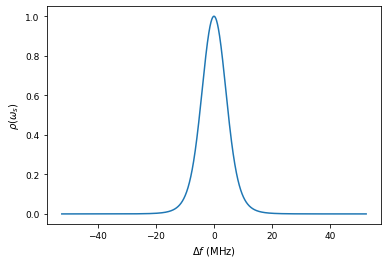

In [3]:
plt.close('all')
matplotlib.interactive(False)
bool_holes = False
bool_inhomo = True
bool_hyperfine = True
spins, gs, pdf = create_spins(gcoll, q, delta, gammaq, nbins,
                              holes=bool_holes, inhomo=bool_inhomo, hyperfine=bool_hyperfine)

plt.figure()
plt.plot(spins, pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('$\\rho(\omega_s)$')
plt.show()

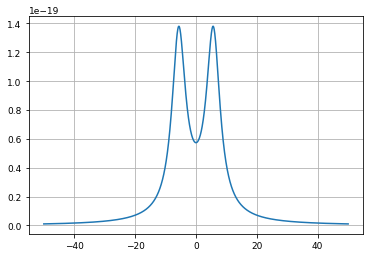

In [4]:
plt.close('all')
matplotlib.interactive(False)
initsteady = (0.1, 0.1)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi, fstart*2*np.pi, 2000)
etasteady = 0.00000001

losasteady = np.zeros(np.shape(deltaarr))


newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady_hp(etasteady, delt, gs, spins,
                         gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2


fig = plt.figure()
plt.plot(deltaarr/2/np.pi, losasteady)
plt.grid(True)
#deltaarr[find(losasteady == max(losasteady))]/2/pi
plt.show()

In [5]:
filepath = "%s/%s" % (spin_pars.folder, spin_pars.reference_trace)
#filepath = "/mnt/samba2/experiments/Quantum InterConnect/Cryogenics/ADR Fridge/DATA/Measurements/20211012_Maser_14/magScan_fit_w_3.mat"
magScan_fit_w_3exp = {}
traceidx = 0
try:
    data = mat73.loadmat(filepath)
except TypeError:
    data = scipy.io.loadmat(filepath, simplify_cells=True)

data = data['trace_avg']
#data = data['tr'][27]
imagpart = data['imagpart']
realpart = data['realpart']
freqStart = data['freqStart']
freqStop = data['freqStop']
numPoints = data['numPoints']

omegap = np.linspace(freqStart, freqStop, numPoints)*2*np.pi*1e-6
freqs = (omegap/2/np.pi -
         1e-6*(freqStart+freqStop)/2)
power = np.squeeze(imagpart**2+realpart**2)

phi = spin_pars.phi
offset_phi = spin_pars.phi_offset
dt = spin_pars.dt
offset = spin_pars.offset
corrected_real, corrected_imag = correct_for_fano(
    omegap, realpart, imagpart, phi, dt, offset, offset_phi)
power_corrected = corrected_real**2+corrected_imag**2
power_uncorrected = realpart**2+imagpart**2

### Fit Coupling

In [6]:
def fitfuncall(freqs, g, ampl, offset, freqoff, gammaq, q, fshift):
    newinit = (0.01, 0.01)
    losasteady = np.zeros(np.shape(freqs))
    spins, gs, pdf = create_spins(g, q, freqoff*2*np.pi, gammaq, nbins,
                                  holes=bool_holes, inhomo=bool_inhomo, hyperfine=bool_hyperfine)

    for i, delt in enumerate(freqs+fshift):
        ar, ai = a_steady_hp(etasteady, delt*2*np.pi, gs,
                             spins, gpar, gperp, kappa, newinit)
        newinit = (ar, ai)
        losasteady[i] = ai**2+ar**2
    losasteady *= ampl/max(abs(losasteady))
    losasteady += offset
    return losasteady


#gcoll, ampl, offset, freqoff, gammaq, fshift
pn = np.array([gcoll, .01, 0, 0, 2*np.pi*8, 0])


def fitfunc(freqs, g, ampl, offset, freqoff, gammaq, fshift): return fitfuncall(
    freqs, g, ampl, offset, freqoff, gammaq, q, -fshift)


popt, pcov = scipy.optimize.curve_fit(
    fitfunc, freqs, power_corrected.ravel(), p0=pn)

Coupling: 4.50 MHz
Linewidth: 9.38 MHz
q-value: 1.310000
Frequency offset: -0.05 MHz
Cooperativity is: 4.401483


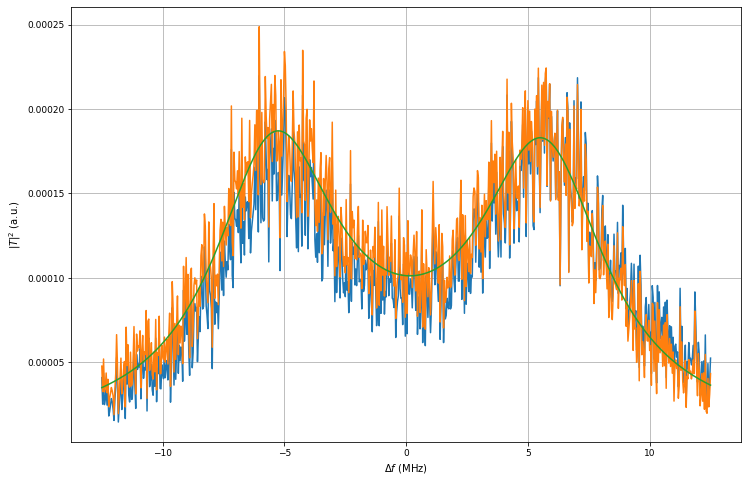

In [7]:
# popt=pn
plt.close('all')
matplotlib.interactive(False)
plt.figure(figsize=(12, 8))
plt.plot(freqs, power_uncorrected)
plt.plot(freqs, power_corrected)
plt.plot(freqs, fitfunc(freqs, *popt))
plt.grid(True)
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('$|T|^2$ (a.u.)')
print('Coupling: %.2f MHz' % (popt[0]/2/np.pi))
print('Linewidth: %.2f MHz' % (popt[4]/2/np.pi))
print('q-value: %f' % q)
print('Frequency offset: %.2f MHz' % (popt[3]))
#print('Frequency shift: %.4f MHz'%popt2[-1])
# %popt[0]
spins, gs, pdf = create_spins(popt[0], q, 0, popt[4], nbins,
                              holes=bool_holes, inhomo=bool_inhomo, hyperfine=bool_hyperfine)
coop = popt[0]**2/kappa*np.sum(pdf/(gperp+1j*2*np.pi*spins))
print("Cooperativity is: %f" % coop.real)
plt.show()

In [8]:
freqsn = np.linspace(-20, 20, 1001)
magnetic_field_conversion = 2.8
magfield = np.linspace(-200, 200, 201)
freq_offs = magfield / magnetic_field_conversion
spec_traces = np.zeros((len(freq_offs), len(freqsn)))
popt_spec = popt.copy()
popt_spec[-1] = 0
for i, foff in enumerate(freq_offs):
    popt_spec[3] = foff

    trace = fitfunc(freqsn, *popt_spec)
    spec_traces[i, :] = trace

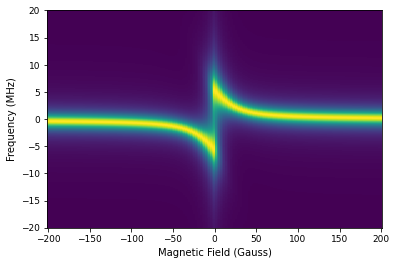

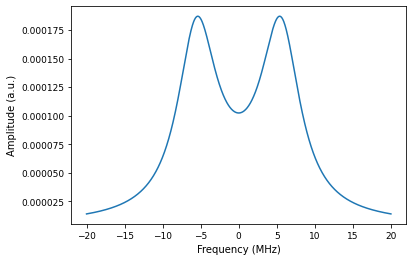

In [9]:
plt.close('all')
plt.figure()
matplotlib.interactive(False)
plt.pcolor(magfield, freqsn, spec_traces.T, shading="auto")
plt.ylabel("Frequency (MHz)")
plt.xlabel("Magnetic Field (Gauss)")
plt.figure()
plt.plot(freqsn, spec_traces[int(len(magfield)/2), :])
plt.xlabel("Frequency (MHz)")
plt.ylabel("Amplitude (a.u.)")
plt.show()

In [10]:
replace_in_file("./_spin_params.py", "gcoll", popt[0])
replace_in_file("./_spin_params.py", "gammaq", popt[4])
replace_in_file("./_spin_params.py", "q", q)